In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib as plt
import itertools as it
from new_analysis_utils import *

%load_ext rpy2.ipython
sns.set_style('whitegrid')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Setup

In [29]:
EXPERIMENT = 5
figs = Figures(path=f'figs/{EXPERIMENT}')
figure = figs.plot
fb_order = ['none', 'action', 'meta']

def write_tex(name, tex):
    file = f"stats/{EXPERIMENT}/{name}.tex"
    with open(file, "w+") as f:
        f.write(str(tex) + r"\unskip")
    print(f'wrote "{tex}" to "{file}"')

def write_percent(name, x):
    write_tex(name, f'{x * 100:.1f}\\%')

def read(stage, name):
    loader = pd.read_csv if name.endswith('csv') else pd.read_json
    df = loader(f'../data/{EXPERIMENT}/stage{stage}/{name}')
    df = drop_nan_cols(df).set_index('wid')
    parse_json(df)
    return df

participants = read(1, 'participants.csv').rename(columns={'completed': 'completed_stage1'})
survey = read(1, 'survey.csv')
stage1 = read(1, 'trials.csv')
stage2 = read(2, 'trials.json')
bonus = read(2, 'bonus.csv').bonus

# Drop participants who didn't finish both sections
# Note: they are still in the participants dataframe for computing retention rates
participants['completed_stage2'] = (stage2.reset_index().wid.value_counts() == 8)
participants.completed_stage2 = participants.completed_stage2.fillna(False)
pdf = participants.query('completed_stage2').copy()
keep = list(pdf.index)
stage1 = stage1.query('wid == @keep').copy()
stage2 = stage2.query('wid == @keep').copy()

stage1['feedback'] = pdf.feedback
stage2['feedback'] = pdf.feedback
pdf['bonus'] = bonus
stage2['n_click'] = stage2.reveals.apply(len)
pdf['stage1_n_click'] = stage1.groupby('wid').n_clicks.mean()
pdf['stage2_n_click'] = stage2.groupby('wid').n_click.mean()

# Demographics

In [6]:
def regularize_gender(s):
    d = {
        'man': 'male',
        'woman': 'female',
        'f': 'female',
        'm': 'male',
    }
    s = s.lower().strip()
    return d.get(s, s)

# age, gender = get_demographics()

# write_tex('mean-age', f'{age.mean():.2f}')
# write_tex('min-age', str(age.min()))
# write_tex('max-age', str(age.max()))
# write_tex("N-female", str(gender.value_counts()['female']))
# write_tex("N-total", len(participants))

N = participants.query('completed_stage1').groupby(['completed_stage2', 'feedback']).apply(len)

for fb in fb_order:
    write_tex(f'N-drop-{fb}', N[False, fb])
    write_percent(f'drop-rate-{fb}', N[False, fb] / N[:, fb].sum())
write_percent('drop-rate', N[False].sum() / N.sum())
write_tex('return-N', N[True].sum())

write_tex('mean-bonus', f'\\${bonus.loc[pdf.index].mean():.2f}')

N.sum()

wrote "31" to "stats/5/N-drop-none.tex"
wrote "17.2\%" to "stats/5/drop-rate-none.tex"
wrote "35" to "stats/5/N-drop-action.tex"
wrote "19.2\%" to "stats/5/drop-rate-action.tex"
wrote "25" to "stats/5/N-drop-meta.tex"
wrote "13.8\%" to "stats/5/drop-rate-meta.tex"
wrote "16.8\%" to "stats/5/drop-rate.tex"
wrote "452" to "stats/5/return-N.tex"
wrote "\$0.95" to "stats/5/mean-bonus.tex"


543

# Transfer performance

figs/5/transfer_bonus.pdf


<function __main__.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

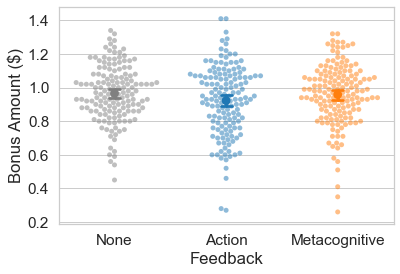

In [17]:
def plot_transfer(outcome):
    sns.swarmplot('feedback', outcome, data=pdf, palette=palette, alpha=0.5, order=fb_order)
    sns.pointplot('feedback', outcome, data=pdf, palette=palette, order=fb_order, 
                  scale=1, capsize=0.1, markers='o')
    plt.xlabel('Feedback')
    plt.ylabel(nice_names[outcome])
    # test = 'Test' if EXPERIMENT == 1 else 'Transfer'
    reformat_labels()

figure(outcome='bonus')(plot_transfer)

figs/5/transfer_stage2_n_click.pdf


<function __main__.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

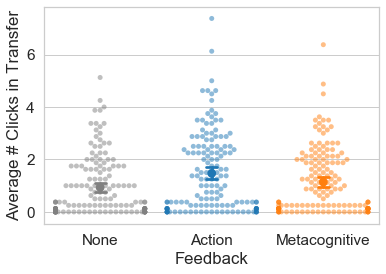

In [18]:
figure(outcome='stage2_n_click')(plot_transfer)

# Backward planning

## Training

In [45]:
leaves = {3,4,7,8,11,12}

def stage1_backward(clicks):
    if not clicks:
        return False
    first = clicks[0]
    return first in leaves

stage1['backward'] = stage1.clicks.apply(stage1_backward)

pdf['stage1_backward'] = stage1.groupby('wid').backward.mean()
pdf.groupby('feedback').stage1_backward.mean()

feedback
action    0.542857
meta      0.851282
none      0.607383
Name: stage1_backward, dtype: float64

figs/5/learning_curve_backward.pdf


<function __main__.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

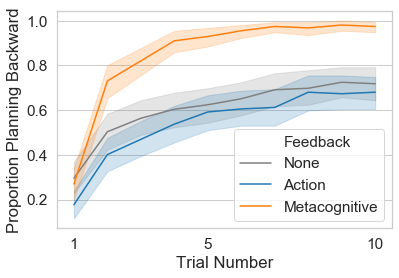

In [20]:
def learning_curve(var):
    df = stage1.copy()
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()

figure(var='backward')(learning_curve)

## Transfer

In [30]:
import networkx as nx

def make_graph(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    return G

def get_goals(G):
    goal = [k for (k, v) in G.out_degree if v == 0]
    return set(goal)

def click_goal_first(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return row.reveals[0][0] in goals

def ever_goal(row):
    if not row.reveals:
        return False
    else:
        goals = get_goals(row.graph)
        return any(x[0] in goals for x in row.reveals)

def num_goal(row):
    if not row.reveals:
        return 0
    else:
        goals = get_goals(row.graph)
        return sum(x[0] in goals for x in row.reveals)

stage2['graph'] = stage2.edges.apply(make_graph)
stage2['backward'] = stage2.apply(click_goal_first, axis=1)
stage2['ever_goal'] = stage2.apply(ever_goal, axis=1)
stage2['num_goal'] = stage2.apply(num_goal, axis=1)

pdf['stage2_backward'] = stage2.groupby('wid').backward.mean()
pdf['stage2_ever_goal'] = stage2.groupby('wid').ever_goal.mean()
pdf['stage2_num_goal'] = stage2.groupby('wid').num_goal.mean()

In [31]:
pdf.groupby('feedback').stage2_backward.mean().round(2)

pdf['stage2_backward_one'] = stage2.query('trial_index == 0').backward
pdf.groupby('feedback').stage2_backward_one.mean().round(2)

pdf.groupby('feedback').stage2_num_goal.mean()
pdf.groupby('feedback').stage2_ever_goal.mean()

pdf.groupby('feedback').stage2_num_goal.mean()
pdf.groupby('feedback').stage2_ever_goal.mean()

feedback
action    0.417517
meta      0.387821
none      0.308725
Name: stage2_ever_goal, dtype: float64

In [32]:
%R -i pdf
%R print(summary(lm(stage2_num_goal ~ feedback, data=pdf)));


Call:
lm(formula = stage2_num_goal ~ feedback, data = pdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8180 -0.7059 -0.5680  0.6820  2.3012 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.81803    0.07275  11.245   <2e-16 ***
feedbackmeta -0.11210    0.10138  -1.106   0.2695    
feedbacknone -0.24420    0.10253  -2.382   0.0176 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.882 on 449 degrees of freedom
Multiple R-squared:  0.01251,	Adjusted R-squared:  0.008111 
F-statistic: 2.844 on 2 and 449 DF,  p-value: 0.05924



figs/5/learning_curve_backward.pdf


<function __main__.Figures.plot.<locals>.decorator.<locals>.wrapped(*args, **kwargs)>

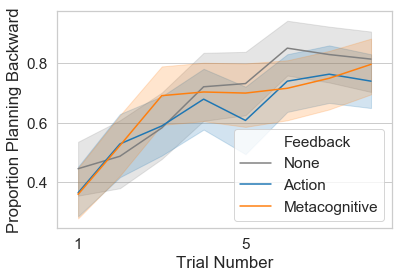

In [40]:
def learning_curve(var):
    # df = {1: stage1, 2: stage2}[stage].copy()
    df = stage2.copy().query('n_click > 0')  # NOTE: excluding non-clicking trials
    df.trial_index += 1
    sns.lineplot('trial_index', var, hue='feedback', 
                 data=df, hue_order=fb_order, palette=palette)
    plt.ylabel(nice_names[var])
    plt.xlabel('Trial Number')
    plt.gca().grid(axis='x')
    plt.xticks([1, *range(5, 31, 5)])
    plt.xlim(df.trial_index.min()-0.5, df.trial_index.max()+0.5)
    reformat_legend()

# figure(stage=1, var='backward')(learning_curve)
figure(var='backward')(learning_curve)

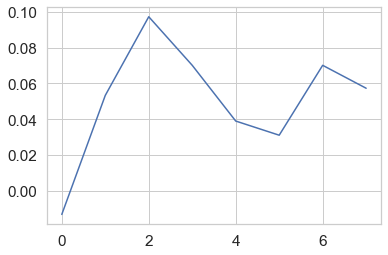

In [51]:
g = stage2.groupby(['feedback', 'trial_index']).backward.mean()
plt.plot(g['meta'] - g['none'])

Text(0, 0.5, 'Proportion')

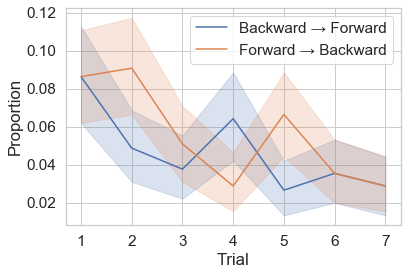

In [55]:
np.diff([1, 1, 0, 0])
stage2.backward.groupby('wid').apply(lambda d: sum(np.diff(d.astype(int)))).value_counts()

b = stage2.backward.astype(int)
diff = b - b.shift(1)
stage2['DB'] = diff
stage2.loc[lambda row: row.trial_index == 0, 'DB'] = np.nan

stage2['D1'] = stage2.DB == 1
stage2['D0'] = stage2.DB == 0
stage2['DN'] = stage2.DB == -1
sns.lineplot('trial_index', 'DN', data=stage2.query('trial_index > 0'), label='Backward → Forward')
sns.lineplot('trial_index', 'D1', data=stage2.query('trial_index > 0'), label='Forward → Backward')
# sns.lineplot('trial_index', 'D0', data=stage2, label='No Change')
plt.xlabel('Trial')
plt.ylabel('Proportion')

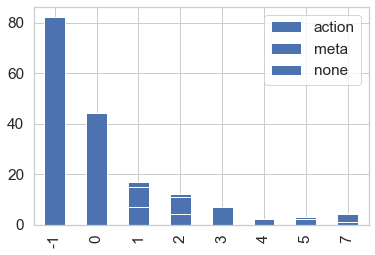

In [58]:
def first_backward(d):
    if not any(d):
        return -1
    return np.argmax(list(d))

pdf['first_backward'] = stage2['backward'].groupby('wid').apply(first_backward)
pdf.groupby('feedback').first_backward.value_counts().sort_index()   

In [59]:
x = {fb: d.pivot(None, 'trial_index', 'backward').values
 for fb, d in stage2.groupby('feedback')}

action 0.4421768707482993
meta 0.44871794871794873
none 0.5503355704697986
figs/5/bas_plot.pdf


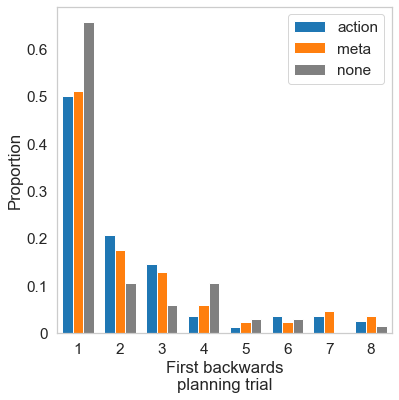

In [60]:
from matplotlib.ticker import FormatStrFormatter

x = {fb: d.pivot(None, 'trial_index', 'backward').values
 for fb, d in stage2.groupby('feedback')}

@figure()
def bas_plot():
    fig,ax=plt.subplots(figsize=(6,6))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    for i,key in enumerate(x.keys()):
        y = x[key][np.sum(x[key],axis=1)>0]
        print(key,(len(x[key])-len(y))/len(x[key]))
        ax.bar(x=np.arange(1,9)+i/4-1/4,height=np.bincount(np.argmax(y,axis=1),minlength=8)/len(y),
               width=1/4,label=key, color=palette[key])
    ax.set_xticks(range(1,9))
    ax.set_xlim([0.5,8.5])
    ax.set_xlabel('First backwards\nplanning trial')
    ax.set_ylabel('Proportion')
    plt.grid()
    ax.legend()

figs/5/transfer_backward.pdf


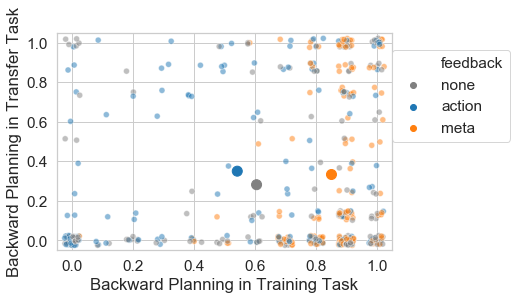

In [61]:
@figure()
def transfer_backward(pdf=pdf):
    pdf = pdf.copy()
    pdf.stage1_backward += 0.05* (np.random.rand(len(pdf)) - 0.5)
    pdf.stage2_backward += 0.05* (np.random.rand(len(pdf)) - 0.5)
    sns.scatterplot('stage1_backward', 'stage2_backward', data=pdf, hue='feedback', 
                    hue_order=fb_order, palette=palette, alpha=0.5)
    
    g = pdf.groupby('feedback')
    fbs = g.stage1_backward.mean().index
    plt.scatter(g.stage1_backward.mean(), g.stage2_backward.mean(), 
        color=[palette[fb] for fb in fbs], s=100)


    plt.xlabel('Backward Planning in Training Task')
    plt.ylabel('Backward Planning in Transfer Task')
    reformat_legend()
    plt.legend(loc=(1,0.5))
    plt.xlim(-0.05,1.05); plt.ylim(-0.05, 1.05)

# Other

figs/5/backward_bonus.pdf


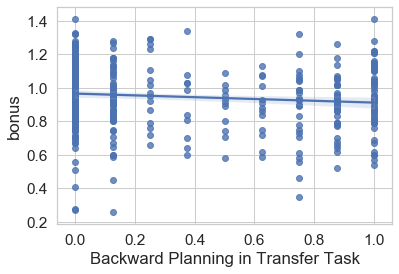

In [62]:
@figure()
def backward_bonus():
    sns.regplot('stage2_backward', 'bonus', data=pdf)
    plt.xlabel('Backward Planning in Transfer Task')

figs/5/backward_bonus_trial.pdf


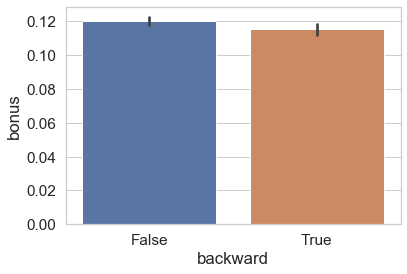

In [63]:
@figure()
def backward_bonus_trial():
    sns.barplot('backward', 'bonus', data=stage2)

In [ ]:
rdf = stage2.reset_index()[['wid', 'feedback', 'no_reveal']]
rdf.no_reveal = rdf.no_reveal.astype(int)

In [ ]:
%%R -i rdf
library(lme4)
m = glmer(no_reveal ~ feedback + (1|wid), family=binomial, data=rdf)
summary(m)

In [65]:
stage2['no_reveal'] = stage2.n_click == 0
pdf['no_reveal'] = stage2.no_reveal.groupby('wid').mean()
rdf = pdf.reset_index()

In [68]:
%%R -i rdf
summary(lm(bonus ~ no_reveal, data=rdf))


Call:
lm(formula = bonus ~ no_reveal, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62872 -0.10438  0.01128  0.12208  0.54208 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.86792    0.01247  69.626   <2e-16 ***
no_reveal    0.16646    0.01946   8.552   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1721 on 450 degrees of freedom
Multiple R-squared:  0.1398,	Adjusted R-squared:  0.1379 
F-statistic: 73.14 on 1 and 450 DF,  p-value: < 2.2e-16



In [72]:
%%R
rdf$feedback = relevel(factor(rdf$feedback), ref="none")
summary(lm(bonus ~ feedback, data=rdf))


Call:
lm(formula = bonus ~ feedback, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69801 -0.10550  0.00735  0.12851  0.48735 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.965503   0.015143  63.760   <2e-16 ***
feedbackaction -0.042850   0.021488  -1.994   0.0467 *  
feedbackmeta   -0.007491   0.021174  -0.354   0.7237    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1848 on 449 degrees of freedom
Multiple R-squared:  0.01002,	Adjusted R-squared:  0.005612 
F-statistic: 2.273 on 2 and 449 DF,  p-value: 0.1042



In [74]:
%%R
summary(lm(stage2_backward ~ feedback, data=rdf)) 


Call:
lm(formula = stage2_backward ~ feedback, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3495 -0.3341 -0.2245  0.4159  0.7164 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.28356    0.03280   8.646   <2e-16 ***
feedbackaction  0.06593    0.04654   1.417    0.157    
feedbackmeta    0.05058    0.04586   1.103    0.271    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4003 on 449 degrees of freedom
Multiple R-squared:  0.004898,	Adjusted R-squared:  0.000465 
F-statistic: 1.105 on 2 and 449 DF,  p-value: 0.3321



In [75]:
%%R
summary(glm(stage2_backward_one ~ feedback, family=binomial, data=rdf)) 


Call:
glm(formula = stage2_backward_one ~ feedback, family = binomial, 
    data = rdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8366  -0.8141  -0.8087   1.5619   1.5980  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.86977    0.17959  -4.843 1.28e-06 ***
feedbackaction -0.08010    0.25705  -0.312    0.755    
feedbackmeta   -0.06454    0.25280  -0.255    0.798    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 540.57  on 451  degrees of freedom
Residual deviance: 540.46  on 449  degrees of freedom
AIC: 546.46

Number of Fisher Scoring iterations: 4



In [76]:
%%R
summary(lm(bonus ~ stage2_n_click + stage2_backward, data=rdf))


Call:
lm(formula = bonus ~ stage2_n_click + stage2_backward, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66922 -0.09969  0.01374  0.09936  0.39029 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.019706   0.009698  105.14  < 2e-16 ***
stage2_n_click  -0.116276   0.007618  -15.26  < 2e-16 ***
stage2_backward  0.206286   0.024499    8.42  5.1e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1497 on 449 degrees of freedom
Multiple R-squared:  0.3505,	Adjusted R-squared:  0.3476 
F-statistic: 121.1 on 2 and 449 DF,  p-value: < 2.2e-16

